# Start Coding

In [62]:
import os
import glob
import numpy as np
import email

In [63]:
path = 'data/spam_data/'

In [64]:
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [65]:
def get_email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

# Split data into train/test

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
ham_path = [
    easy_ham_paths,
    easy_ham_2_paths,
    hard_ham_paths
]

spam_path = [
    spam_paths,
    spam_2_paths
]

In [107]:
ham_sample = np.array([train_test_split(o) for o in ham_path])

In [108]:
ham_train = np.array([])
ham_test = np.array([])
for o in ham_sample:
    ham_train = np.concatenate((ham_train,o[0]),axis=0)
    ham_test = np.concatenate((ham_test,o[1]),axis=0)

In [109]:
ham_train.shape, ham_test.shape

((3113,), (1040,))

In [110]:
spam_sample = np.array([train_test_split(o) for o in spam_path])

In [111]:
spam_train = np.array([])
spam_test = np.array([])
for o in spam_sample:
    spam_train = np.concatenate((spam_train,o[0]),axis=0)
    spam_test = np.concatenate((spam_test,o[1]),axis=0)

In [112]:
spam_train.shape, spam_test.shape

((1422,), (476,))

In [113]:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

In [114]:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [115]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

In [116]:
x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]

In [117]:
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [118]:
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

In [119]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [120]:
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

# Preprocessing

## Process sentence

### Cleaning Up (Part 1)

In [121]:
import re
import string
from nltk.tokenize import word_tokenize

In [122]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [123]:
def to_lower(word):
    result = word.lower()
    return result

In [124]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [125]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [126]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [127]:
def replace_newline(word):
    return word.replace('\n','')

In [128]:
def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [129]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

### Cleaning Up (Part 2)

In [130]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [131]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [132]:
# Tokenization are taking slightly longer to process

x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [133]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [134]:
def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

In [135]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

In [136]:
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words,word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

In [137]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [149]:
x_train = [" ".join(o) for o in x_train]
x_test = [" ".join(o) for o in x_test]

# Visualization

This section of visualization code is referred from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

## Wordcloud

In [151]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [152]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [153]:
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]

In [154]:
spam_email = np.array(x_train)[spam_train_index]
non_spam_email = np.array(x_train)[non_spam_train_index]

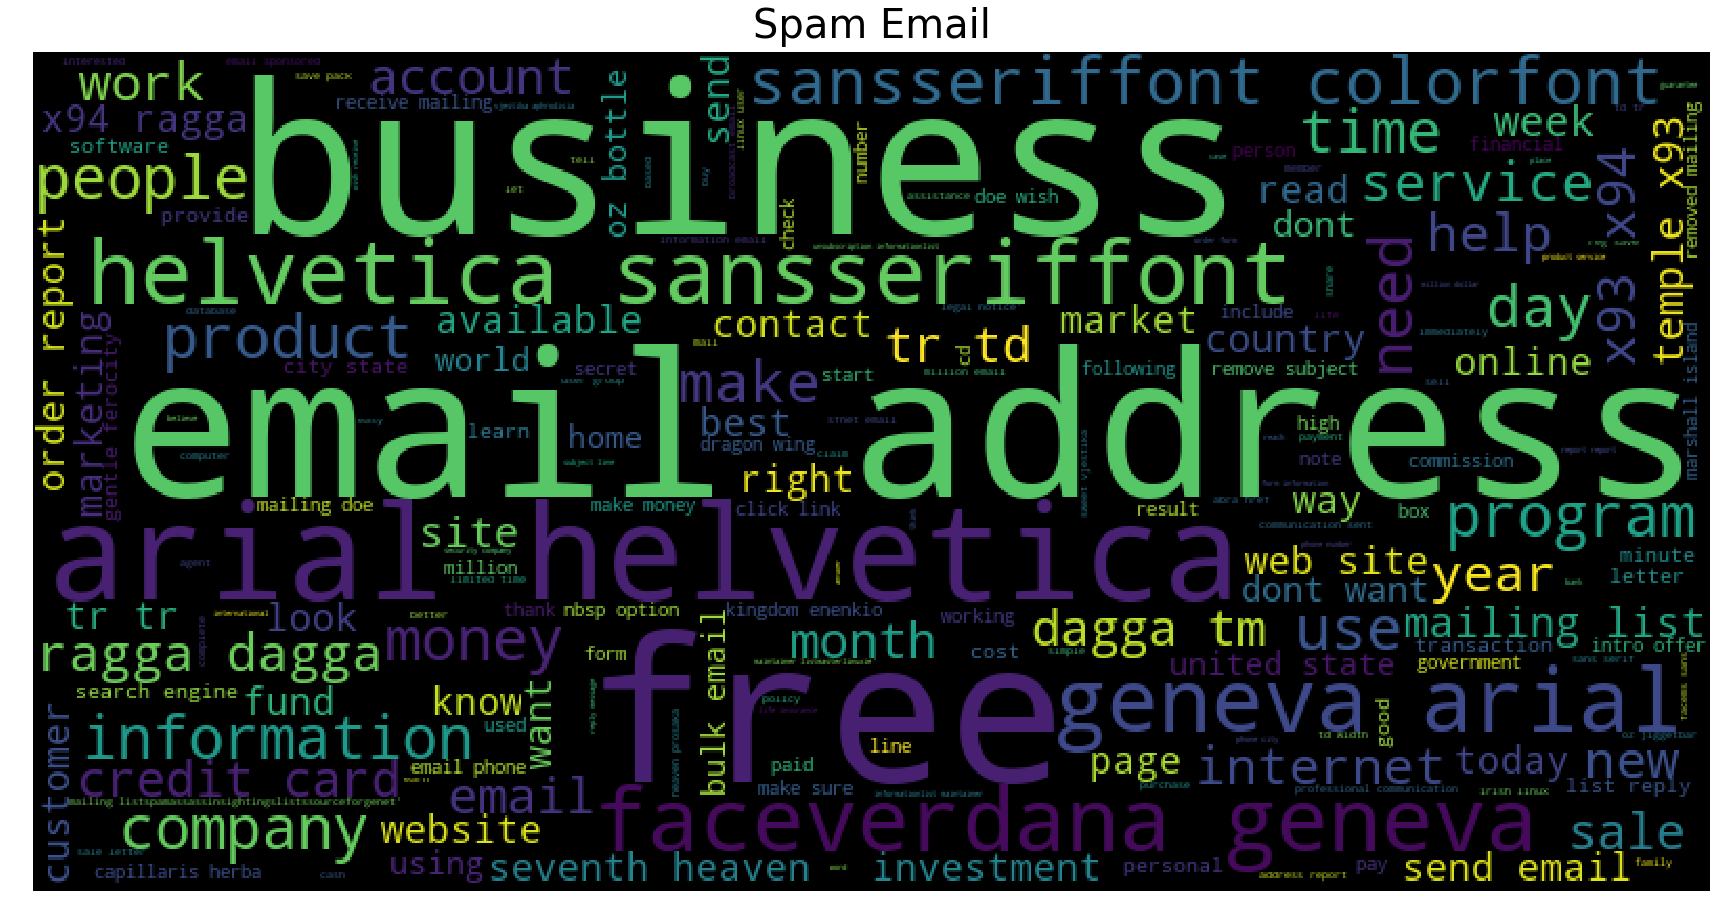

In [155]:
plot_wordcloud(spam_email,title = 'Spam Email')

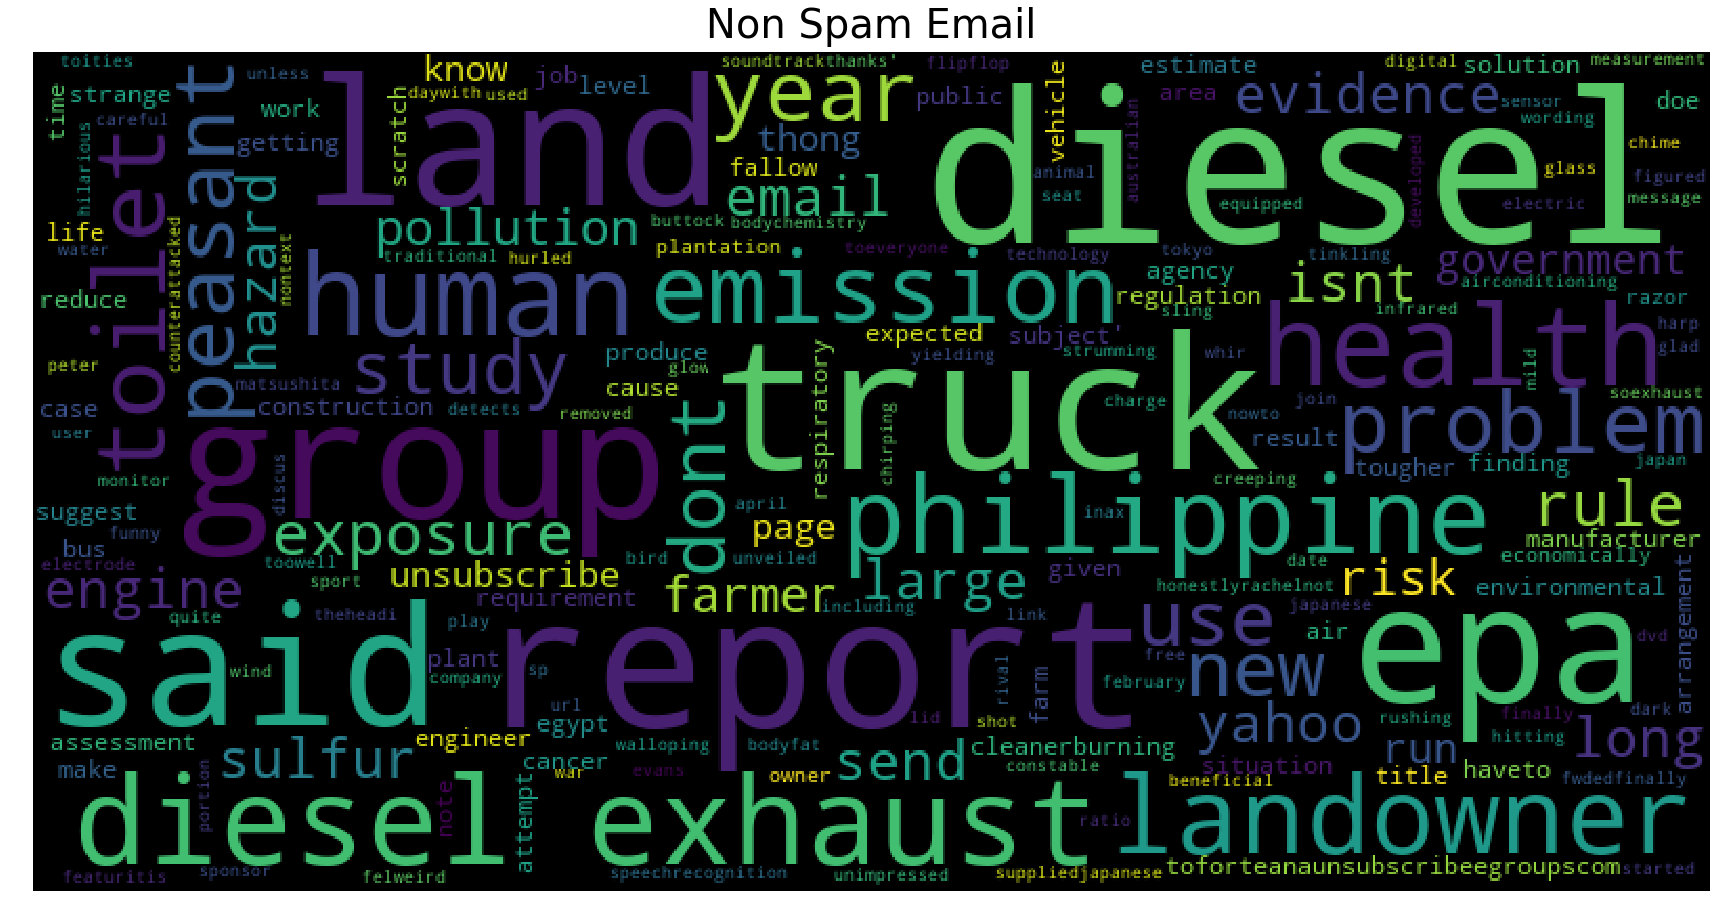

In [156]:
plot_wordcloud(non_spam_email,title="Non Spam Email")

# Visualizing using bar chart

In [157]:
from collections import defaultdict
import pandas as pd
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [158]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


In [159]:
def visualize_in_bar_chart(word_count=1):
    ## Get the bar chart from sincere questions ##
    freq_dict = defaultdict(int)
    for sent in non_spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')

    ## Get the bar chart from insincere questions ##
    freq_dict = defaultdict(int)
    for sent in spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace1 = horizontal_bar_chart(fd_sorted.head(20), 'blue')

    # Creating two subplots
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of non spam email", 
                                              "Frequent words of spam email"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=600, width=800, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')

In [160]:
visualize_in_bar_chart(1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## Target Distribution

In [161]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [162]:
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]

In [163]:
spam_size = len(spam_train_index)
non_spam_size = len(non_spam_train_index)
total_train_size = spam_size + non_spam_size

trace = go.Bar(
    x=["Spam","Non Spam"],
    y=[spam_size, non_spam_size],
    marker=dict(
        color=[spam_size, non_spam_size],
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count for Train Data',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(["Spam", "Non Spam"]))
sizes = (np.array(([spam_size,non_spam_size]))/total_train_size*100)

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Train Data distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [164]:
spam_test_index = [i for i,o in enumerate(y_test) if o == 1]
non_spam_test_index = [i for i,o in enumerate(y_test) if o == 0]

spam_size = len(spam_test_index)
non_spam_size = len(non_spam_test_index)
total_test_size = spam_size + non_spam_size

trace = go.Bar(
    x=["Spam","Non Spam"],
    y=[spam_size, non_spam_size],
    marker=dict(
        color=[spam_size, non_spam_size],
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count for Test Data',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(["Spam", "Non Spam"]))
sizes = (np.array(([spam_size,non_spam_size]))/total_train_size*100)

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Test Data Distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

# Feature Extraction

## TfidVectorizer

In [183]:
x_train = [o.split(" ") for o in x_train]
x_test = [o.split(" ") for o in x_test]

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
vectorizer = TfidfVectorizer()
raw_sentences = [' '.join(o) for o in x_train]
vectorizer.fit(raw_sentences)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [186]:
def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(o) for o in raw_tokenize_data]
    return vectorizer.transform(raw_sentences)

In [187]:
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)

## CountVectorizer

In [188]:
from sklearn.feature_extraction.text import CountVectorizer

In [189]:
vectorizer = CountVectorizer()
raw_sentences = [' '.join(o) for o in x_train]
vectorizer.fit(raw_sentences)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [190]:
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)

## Training classifier

## Gaussian NB

In [191]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [192]:
clf = GaussianNB()

In [193]:
clf.fit(x_train_features.toarray(),y_train)

GaussianNB(priors=None)

In [194]:
clf.score(x_test_features.toarray(),y_test)

0.9386792452830188

In [195]:
clf.score(x_train_features.toarray(),y_train)

0.9960567823343849

## Error Analysis

### Gaussian NB

In [196]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [197]:
y_predict = clf.predict(x_test_features.toarray())

In [198]:
confusion_matrix(y_test,y_predict)

array([[983,  29],
       [ 49, 211]])

In [199]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

In [200]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Precision: 87.92%
Recall: 81.15%


### Plot confusion matrix

In [201]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [202]:
cnf_matrix = confusion_matrix(y_test,y_predict)

In [203]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[983  29]
 [ 49 211]]


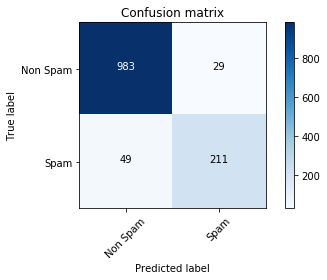

In [204]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=False,
                      title='Confusion matrix')